# Movie Genre Prediction

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
dir = '/content/drive/MyDrive/Encryptix/Genre Classification Dataset'
os.chdir(dir)
print(os.getcwd())
print(os.listdir())

/content/drive/MyDrive/Encryptix/Genre Classification Dataset
['glove.840B.300d.txt', 'description.txt', 'test_data.txt', 'test_data_solution.txt', 'train_data.txt', 'predictions']


### Data Preparation

In [3]:
#Converting raw data to pandas dataframe
def create_dataframe(file):
  with open(file) as f:
    data = f.readlines()
    data = [x.split(':::') for x in data]
    data = pd.DataFrame(np.array(data),columns=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
  return data

In [4]:
train_data = create_dataframe('train_data.txt')
test_data = create_dataframe('test_data_solution.txt')

In [5]:
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  object
 1   TITLE        54214 non-null  object
 2   GENRE        54214 non-null  object
 3   DESCRIPTION  54214 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


No null rows

In [ ]:
# target classes (Movie genres)
train_data['GENRE'].unique()

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

### Distribution of Target Class

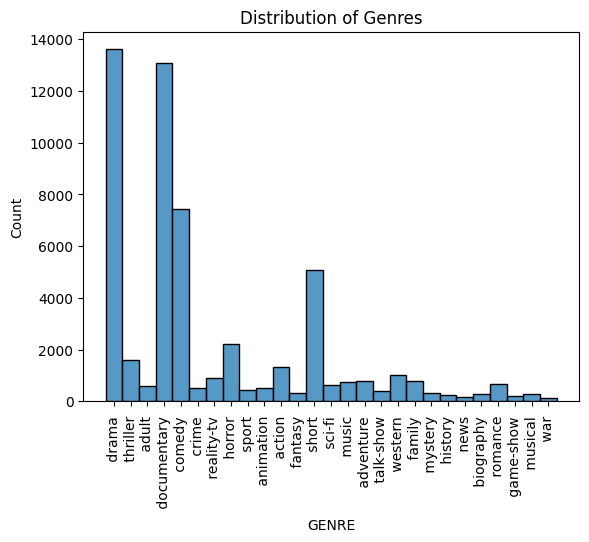

In [9]:
sns.histplot(data=train_data,x='GENRE')
plt.title("Distribution of Genres")
plt.xticks(rotation=90)
plt.show()

There is a clear class imbalance, with a higher number of movies in the drama, documentary, comedy, and short film genres compared to other genres.


### Label Encoding

In [10]:
# converting target class into labels using label encoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['GENRE'])
test_labels = label_encoder.transform(test_data['GENRE'])

In [11]:
train_labels

array([ 8, 24,  1, ...,  7,  5, 12])

### Feature Extraction

In [ ]:
# function to get features from description of movie.
def get_features(feature_extractor,train_data,test_data):
  X_train = feature_extractor.fit_transform(train_data['DESCRIPTION'])
  X_test = feature_extractor.transform(test_data['DESCRIPTION'])
  return X_train,X_test

In [ ]:
# function to load glove embeddings

def load_glove_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
              vector = np.asarray(values[1:], dtype='float32')
            except: pass
            embeddings[word] = vector
    return embeddings

glove_file = 'glove.840B.300d.txt'
embeddings_index = load_glove_embeddings(glove_file)


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

embedding_dim = 300

def documents_to_vector(data, embeddings_index, embedding_dim):
  ans = []
  for document in data:
    tokens = word_tokenize(document.lower())
    vectors = []
    for word in tokens:
      if word in embeddings_index:
          vectors.append(embeddings_index[word])
      else:
          vectors.append(np.zeros(embedding_dim))
    ans.append(np.mean(vectors, axis=0))
  return ans

word_vectors = documents_to_vector(train_data, embeddings_index, embedding_dim)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


I converted the descriptions into vector data using pretrained GloVe embeddings. For each description, I calculated the embedding vector by averaging the embeddings of all the words in the description.

In [ ]:
features = [CountVectorizer(stop_words='english'), TfidfVectorizer(stop_words='english')]
f1 = get_features(features[0],train_data,test_data)
f2 = get_features(features[1],train_data,test_data)

Additionally, I employed two more text feature extraction techniques, CountVectorizer and TfidfVectorizer, which I imported from sklearn.

In [ ]:
f3 = documents_to_vector(train_data['DESCRIPTION'], embeddings_index, embedding_dim)
f4 = documents_to_vector(test_data['DESCRIPTION'], embeddings_index, embedding_dim)

In [ ]:
# Reduce dimensionality using TruncatedSVD
n_components = 300    # same as glove embeddings

svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

# Apply the LSA (Latent Semantic Analysis) transformation
f1_train = lsa.fit_transform(f1[0])
f1_test = lsa.transform(f1[1])

svd_ = TruncatedSVD(n_components)
normalizer_ = Normalizer(copy=False)
lsa_ = make_pipeline(svd_, normalizer_)

f2_train = lsa_.fit_transform(f2[0])
f2_test = lsa_.transform(f2[1])


I reduced the dimensions of the features extracted from CountVectorizer and TfidfVectorizer to 300 dimensions, matching the dimensions of the GloVe embeddings. This was necessary because their original dimensions were very large and sparse, making them inefficient in terms of time.

In [ ]:
train_features = [f1_train , f2_train , np.array(f3)]
test_features = [f1_test , f2_test , np.array(f4)]


### Training Models

In [ ]:
models = [GaussianNB , LogisticRegression , SVC]
model_names = ["GaussianNB" , "LogisticRegression" , "SVC"]
feature_names = ["CountVectorizer" , "TfidfVectorizer" , "GloVe"]
predictions = {}
for m in range(3):
  predictions[model_names[m]]={}
  for f,feature in enumerate(feature_names):
    predictions[model_names[m]][feature]={}
    metric = predictions[model_names[m]][feature]
    train_feature = train_features[f]
    test_feature = test_features[f]
    model = models[m]()
    model.fit(train_feature,train_labels)
    metric['pred'] = model.predict(test_feature)
    metric['accuracy'] = accuracy_score(test_labels,metric['pred'])
    metric['f1'] = f1_score(test_labels,metric['pred'],average='weighted')
    metric['cm'] = confusion_matrix(test_labels,metric['pred'])

I trained the data using three different classifiers—Naive Bayes, Logistic Regression, and Support Vector Classifier—using all three types of extracted features.

In [ ]:
accs = []
for m in model_names:
  s = []
  for f in feature_names:
    s.append(round(predictions[m][f]['accuracy'],4))
  accs.append(s)
accs = np.array(accs)

### Results

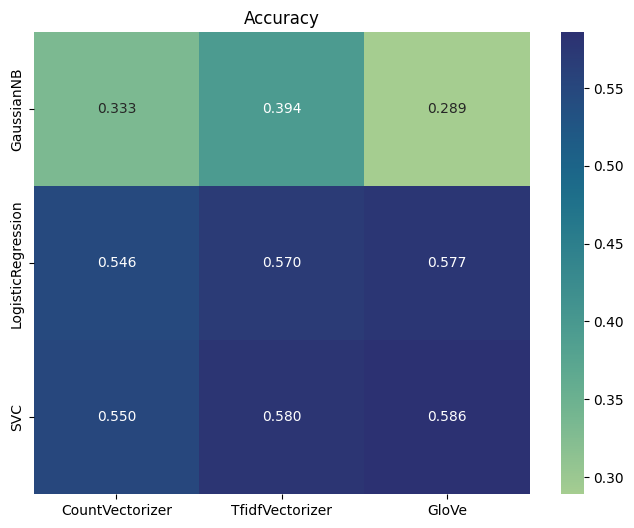

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
ax = sns.heatmap(accs,annot=True,xticklabels=feature_names,yticklabels=model_names,fmt=".3f",cmap="crest")
ax.set_title("Accuracy")
plt.show()

From the plot, we can observe that the Support Vector Classifier with GloVe embeddings achieves the highest accuracy of 0.586 compared to all other methods.

### Confusion Matrix

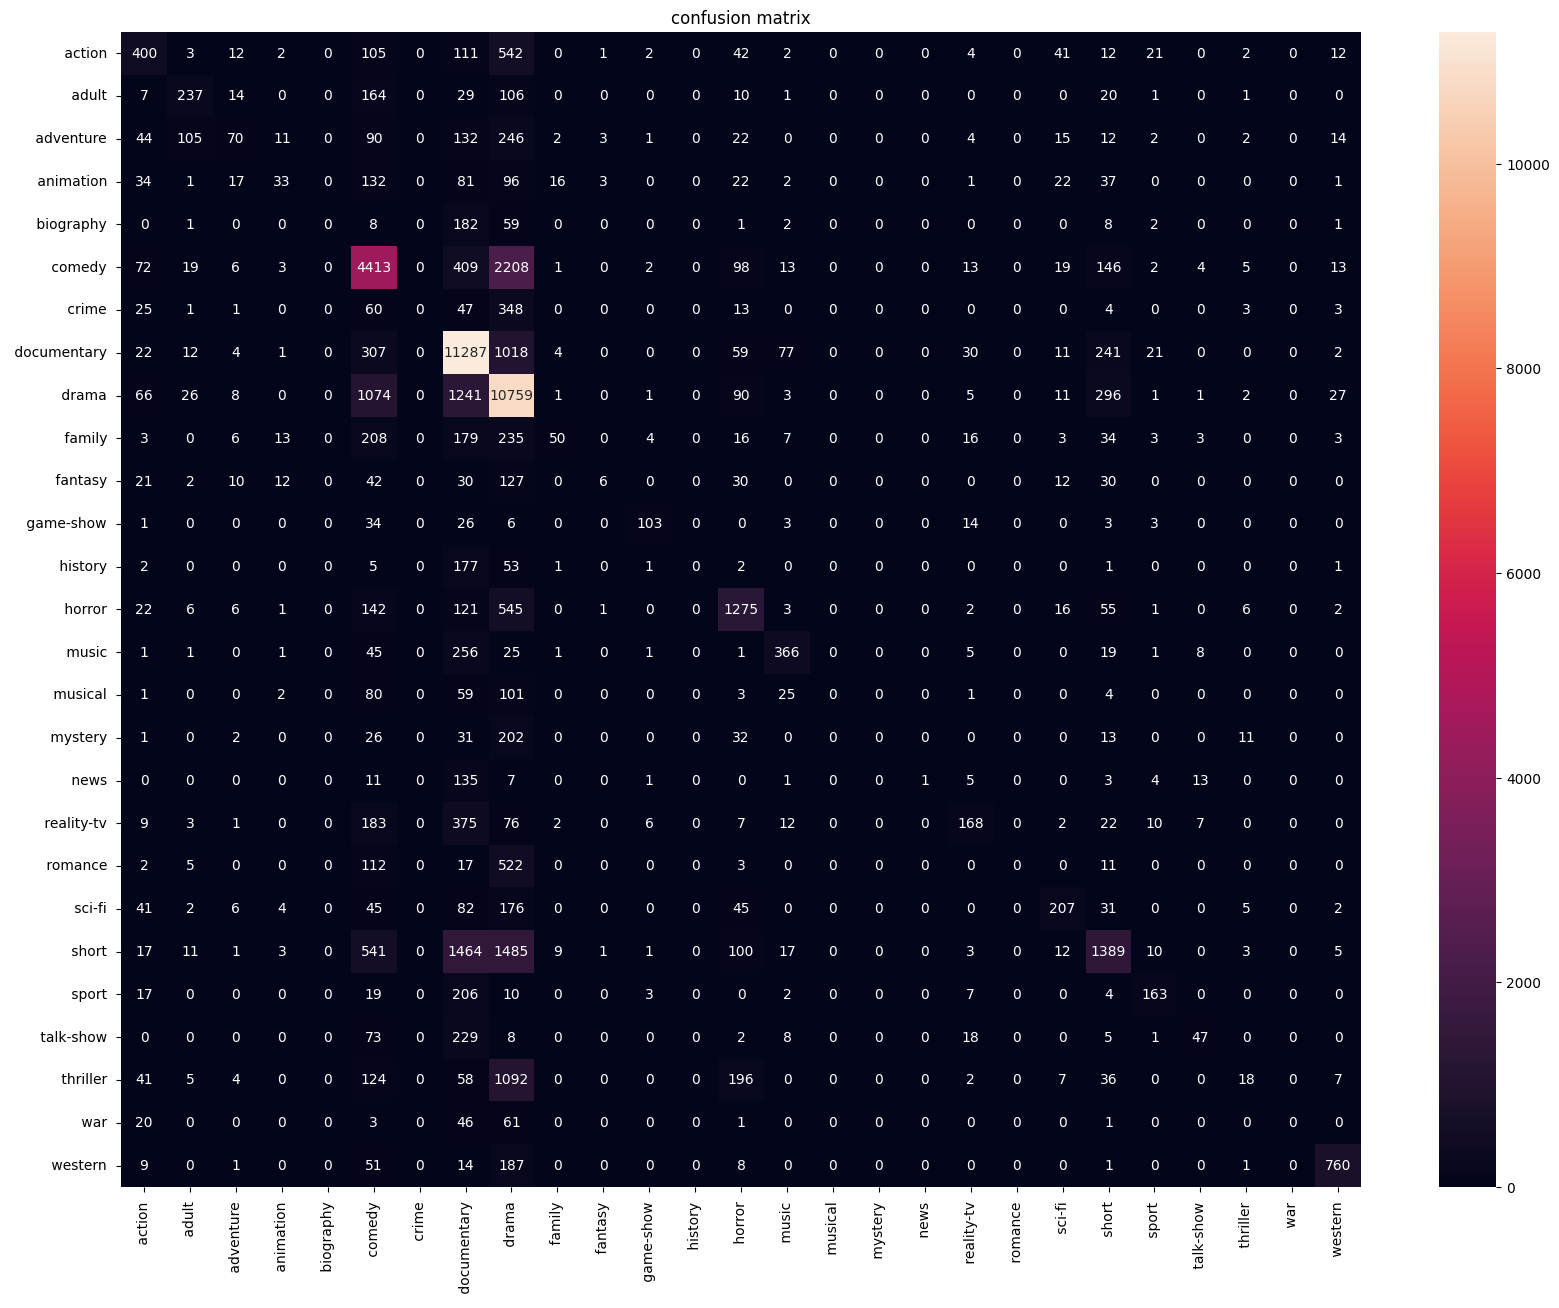

In [ ]:
cm = predictions['SVC']['GloVe']['cm']
plt.figure(figsize=(20, 15))
ax = sns.heatmap(cm,annot=True,fmt='.0f',xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)
ax.set_title("confusion matrix")
plt.show()
